In [2]:
%matplotlib inline

import numpy as np
import requests

import shapely
import picogeojson
from shapely import geometry
import georasters as gr
from affine import Affine
from descartes import PolygonPatch
from rasterstats import zonal_stats
import fiona


import matplotlib.pyplot as plt
import rasterio

import gdal
from gdalconst import *
from osgeo import ogr

from io import BytesIO

import tempfile

In [3]:
pt = picogeojson.fromstring("""{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": "ESP", "name": "Spain" }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -9.034818, 41.880571 ], [ -8.984433, 42.592775 ], [ -9.392884, 43.026625 ], [ -7.97819, 43.748338 ], [ -6.754492, 43.567909 ], [ -5.411886, 43.57424 ], [ -4.347843, 43.403449 ], [ -3.517532, 43.455901 ], [ -1.901351, 43.422802 ], [ -1.502771, 43.034014 ], [ 0.338047, 42.579546 ], [ 0.701591, 42.795734 ], [ 1.826793, 42.343385 ], [ 2.985999, 42.473015 ], [ 3.039484, 41.89212 ], [ 2.091842, 41.226089 ], [ 0.810525, 41.014732 ], [ 0.721331, 40.678318 ], [ 0.106692, 40.123934 ], [ -0.278711, 39.309978 ], [ 0.111291, 38.738514 ], [ -0.467124, 38.292366 ], [ -0.683389, 37.642354 ], [ -1.438382, 37.443064 ], [ -2.146453, 36.674144 ], [ -3.415781, 36.6589 ], [ -4.368901, 36.677839 ], [ -4.995219, 36.324708 ], [ -5.37716, 35.94685 ], [ -5.866432, 36.029817 ], [ -6.236694, 36.367677 ], [ -6.520191, 36.942913 ], [ -7.453726, 37.097788 ], [ -7.537105, 37.428904 ], [ -7.166508, 37.803894 ], [ -7.029281, 38.075764 ], [ -7.374092, 38.373059 ], [ -7.098037, 39.030073 ], [ -7.498632, 39.629571 ], [ -7.066592, 39.711892 ], [ -7.026413, 40.184524 ], [ -6.86402, 40.330872 ], [ -6.851127, 41.111083 ], [ -6.389088, 41.381815 ], [ -6.668606, 41.883387 ], [ -7.251309, 41.918346 ], [ -7.422513, 41.792075 ], [ -8.013175, 41.790886 ], [ -8.263857, 42.280469 ], [ -8.671946, 42.134689 ], [ -9.034818, 41.880571 ] ] ] } }
]
}
""")

In [4]:
pt

FeatureCollection(features=[Feature(geometry=Polygon(), properties={'name': 'Spain', 'id': 'ESP'})])

In [5]:
# Coordenadas del polígono
for feature in pt.features:
    print(feature.geometry.coordinates[0]) # Esto hay que generalizarlo

[[-9.034818, 41.880571], [-8.671946, 42.134689], [-8.263857, 42.280469], [-8.013175, 41.790886], [-7.422513, 41.792075], [-7.251309, 41.918346], [-6.668606, 41.883387], [-6.389088, 41.381815], [-6.851127, 41.111083], [-6.86402, 40.330872], [-7.026413, 40.184524], [-7.066592, 39.711892], [-7.498632, 39.629571], [-7.098037, 39.030073], [-7.374092, 38.373059], [-7.029281, 38.075764], [-7.166508, 37.803894], [-7.537105, 37.428904], [-7.453726, 37.097788], [-6.520191, 36.942913], [-6.236694, 36.367677], [-5.866432, 36.029817], [-5.37716, 35.94685], [-4.995219, 36.324708], [-4.368901, 36.677839], [-3.415781, 36.6589], [-2.146453, 36.674144], [-1.438382, 37.443064], [-0.683389, 37.642354], [-0.467124, 38.292366], [0.111291, 38.738514], [-0.278711, 39.309978], [0.106692, 40.123934], [0.721331, 40.678318], [0.810525, 41.014732], [2.091842, 41.226089], [3.039484, 41.89212], [2.985999, 42.473015], [1.826793, 42.343385], [0.701591, 42.795734], [0.338047, 42.579546], [-1.502771, 43.034014], [-1.901

In [6]:
# BBox
def bbox(coords):
    mat = np.array(coords)
    return [
        np.amin(mat[:, 0]),
        np.amin(mat[:, 1]),
        np.amax(mat[:, 0]),
        np.amax(mat[:, 1])
    ]
for feature in pt.features:
    print(bbox(feature.geometry.coordinates[0]))

[-9.3928840000000005, 35.946849999999998, 3.0394839999999999, 43.748337999999997]


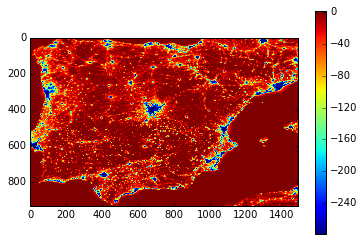

In [7]:
url = "http://54.146.170.2:8080/rasdaman/ows?&SERVICE=WCS&VERSION=2.0.1&REQUEST=GetCoverage&COVERAGEID=nightlights&SUBSET=Lat(35.946849999999998,43.748337999999997)&SUBSET=Long(-9.3928840000000005,3.0394839999999999)&FORMAT=text/csv"
r = requests.get(url)
r.raise_for_status()

x = np.array(eval(r.text.replace('{','[').replace('}',']')))
plt.imshow(x.transpose()) # Viene en LatLong
plt.colorbar()

In [8]:
# Geotransform para affine
xmin, ymin, xmax, ymax = [-9.3928840000000005, 35.946849999999998, 3.0394839999999999, 43.748337999999997]
ncols, nrows = x.shape
xres = (xmax-xmin)/float(ncols)
yres = (ymax-ymin)/float(nrows)
geotransform = (xmin,xres,0,ymax,0, -yres) 
geotransform

(-9.392884, 0.008327105157401206, 0, 43.748338, 0, -0.008326027748132337)

In [9]:
# We apply the inverse affine transform to get pixel coordinates
fwd = Affine.from_gdal(*geotransform)
~fwd * (-9.034818, 41.880571)


(43.00005743073257, 224.32870229371565)

In [10]:
new_coordinates = []

for feature in pt.features:
    for coord in feature.geometry.coordinates[0]:
        new_coordinates.append([*(~fwd * coord)])

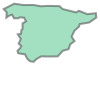

In [11]:
poly = geometry.Polygon(np.array(new_coordinates))

poly2 = geometry.Polygon(np.array(pt.features[0].geometry.coordinates[0]))

poly2

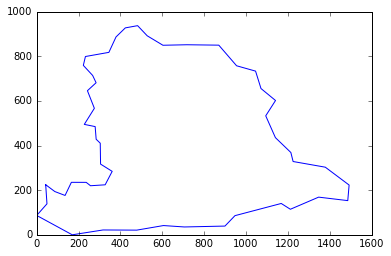

In [12]:
x_coords,y_coords = poly.exterior.xy
plt.plot(x_coords, y_coords)

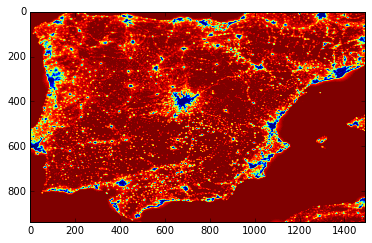

In [13]:
plt.imshow(x.transpose())

/tmp/tmpjx792gl9.tiff
http://54.146.170.2:8080/rasdaman/ows?format=image%2Ftiff&REQUEST=GetCoverage&SERVICE=WCS&version=2.0.1&SUBSET=Lat%2835.946849999999998%2C43.748337999999997%29&SUBSET=Long%28-9.3928840000000005%2C3.0394839999999999%29&COVERAGEID=nightlights


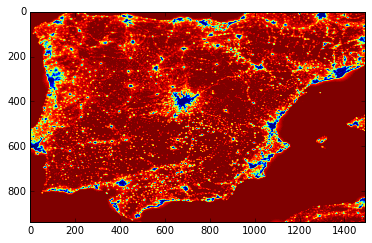

In [14]:
url = "http://54.146.170.2:8080/rasdaman/ows"


query = {
    'SERVICE': 'WCS',
    'version': '2.0.1',
    'REQUEST': 'GetCoverage',
    'COVERAGEID': 'nightlights',
    'SUBSET': [
        'Lat(35.946849999999998,43.748337999999997)',
        'Long(-9.3928840000000005,3.0394839999999999)'
    ],
    'format': 'image/tiff'
}

with tempfile.NamedTemporaryFile(suffix='.tiff') as f:
    print(f.name)
    ret = requests.get(url, stream=True, params=query)
    print(ret.url)
    for chunk in ret.iter_content(chunk_size=1024):
        f.write(chunk)
    dataset = gdal.Open(f.name, GA_ReadOnly)
plt.imshow(dataset.ReadAsArray())

[-9.3928840000000005, 35.946849999999998, 3.0394839999999999, 43.748337999999997]
/tmp/tmpn26e4d_e.tiff
http://54.146.170.2:8080/rasdaman/ows?format=image%2Ftiff&REQUEST=GetCoverage&SERVICE=WCS&version=2.0.1&SUBSET=Lat%2835.946849999999998%2C43.748337999999997%29&SUBSET=Long%28-9.3928840000000005%2C3.0394839999999999%29&COVERAGEID=nightlights


[{'majority': 1.0,
  'max': 1.0,
  'median': -17.0,
  'min': -279.0,
  'std': 56.32360322315812,
  'sum': -22037402.0}]

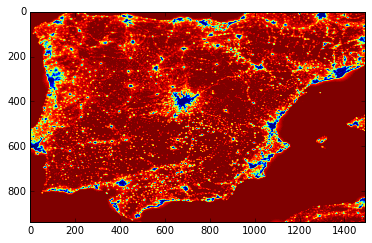

In [19]:
pt = picogeojson.fromstring("""{
"type": "FeatureCollection",
"crs": { "type": "name", "properties": { "name": "urn:ogc:def:crs:OGC:1.3:CRS84" } },
"features": [
{ "type": "Feature", "properties": { "id": "ESP", "name": "Spain" }, "geometry": { "type": "Polygon", "coordinates": [ [ [ -9.034818, 41.880571 ], [ -8.984433, 42.592775 ], [ -9.392884, 43.026625 ], [ -7.97819, 43.748338 ], [ -6.754492, 43.567909 ], [ -5.411886, 43.57424 ], [ -4.347843, 43.403449 ], [ -3.517532, 43.455901 ], [ -1.901351, 43.422802 ], [ -1.502771, 43.034014 ], [ 0.338047, 42.579546 ], [ 0.701591, 42.795734 ], [ 1.826793, 42.343385 ], [ 2.985999, 42.473015 ], [ 3.039484, 41.89212 ], [ 2.091842, 41.226089 ], [ 0.810525, 41.014732 ], [ 0.721331, 40.678318 ], [ 0.106692, 40.123934 ], [ -0.278711, 39.309978 ], [ 0.111291, 38.738514 ], [ -0.467124, 38.292366 ], [ -0.683389, 37.642354 ], [ -1.438382, 37.443064 ], [ -2.146453, 36.674144 ], [ -3.415781, 36.6589 ], [ -4.368901, 36.677839 ], [ -4.995219, 36.324708 ], [ -5.37716, 35.94685 ], [ -5.866432, 36.029817 ], [ -6.236694, 36.367677 ], [ -6.520191, 36.942913 ], [ -7.453726, 37.097788 ], [ -7.537105, 37.428904 ], [ -7.166508, 37.803894 ], [ -7.029281, 38.075764 ], [ -7.374092, 38.373059 ], [ -7.098037, 39.030073 ], [ -7.498632, 39.629571 ], [ -7.066592, 39.711892 ], [ -7.026413, 40.184524 ], [ -6.86402, 40.330872 ], [ -6.851127, 41.111083 ], [ -6.389088, 41.381815 ], [ -6.668606, 41.883387 ], [ -7.251309, 41.918346 ], [ -7.422513, 41.792075 ], [ -8.013175, 41.790886 ], [ -8.263857, 42.280469 ], [ -8.671946, 42.134689 ], [ -9.034818, 41.880571 ] ] ] } }
]
}
""")

poly = geometry.Polygon(np.array(pt.features[0].geometry.coordinates[0]))

url = "http://54.146.170.2:8080/rasdaman/ows"

def bbox(coords):
    mat = np.array(coords)
    return [
        np.amin(mat[:, 0]),
        np.amin(mat[:, 1]),
        np.amax(mat[:, 0]),
        np.amax(mat[:, 1])
    ]
for feature in pt.features:
    print(bbox(feature.geometry.coordinates[0]))

query = {
    'SERVICE': 'WCS',
    'version': '2.0.1',
    'REQUEST': 'GetCoverage',
    'COVERAGEID': 'nightlights',
    'SUBSET': [
        'Lat(35.946849999999998,43.748337999999997)',
        'Long(-9.3928840000000005,3.0394839999999999)'
    ],
    'format': 'image/tiff'
}

with tempfile.NamedTemporaryFile(suffix='.tiff') as f:
    print(f.name)
    ret = requests.get(url, stream=True, params=query)
    print(ret.url)
    for chunk in ret.iter_content(chunk_size=1024):
        f.write(chunk)
    dataset = rasterio.open(f.name)

plt.imshow(dataset.read(1))

zon = zonal_stats(
    poly,
    dataset.read(1),
    affine=dataset.transform,
    nodata=[2.0],
    all_touched=True,
    stats=['min', 'max', 'median', 'majority', 'sum', 'std']
)

In [ ]:
zonal_stats(poly2, dataset.read(1), affine=dataset.transform, nodata=2, all_touched=True)

In [ ]:
dataset.transform

In [34]:
with fiona.open("tmp4wtv6ks7.geo.json", 'r', 'GeoJSON') as source:
    print(source)
    print(zonal_stats(source, dataset.read(1), affine=dataset.transform, nodata=2, all_touched=True))

<open Collection 'tmp4wtv6ks7.geo.json:OGRGeoJSON', mode 'r' at 0x7f4589d77048>
[{'count': 587775, 'max': 1.0, 'min': -279.0, 'mean': -37.49292161116073}]


In [ ]:
zonal_stats(, dataset.read(1), affine=dataset.transform, nodata=2, all_touched=True)